# コード7-1：偏微分方程式の数値計算の実装

『ウイルス感染の数理モデルとシミュレーション ーデータを定量的に理解するー』

偏微分方程式の数値計算の実装の例をまとめる。

## ライブラリ、パッケージ（モジュール）の読み込み

In [8]:
## 必要があればインストール
# install.packages(c("ggplot2", "patchwork", "deSolve"))

In [3]:
rm(list = ls(all = TRUE))
library(ggplot2)
library(patchwork)
library(deSolve)

## 偏微分方程式の数値計算

式(7.2)

$$
\frac{d T(t)}{dt} = g T(t) \left(1 - \frac{T(t) + I(t)}{K} \right) - \beta T(t) V_{I}(t) \\
\frac{d I(t)}{dt} = g I(t) \left(1 - \frac{T(t) + I(t)}{K} \right) + \beta T(t) V_{I}(t) \\
\left(\frac{\partial}{\partial t} + \frac{\partial}{\partial a}\right) r(t, a) = k r(t, a) - (\mu + \rho) r(t, a) \\
\frac{d V_{I}(t)}{dt} = f \rho \int^{\infty}_{0}{r(t, a) da} - r V_{I}(t) - c V_{I}(t) \\
\frac{d V_{NI}(t)}{dt} = (1 - f) \rho \int^{\infty}_{0}{r(t, a) da} + r V_{I}(t) - c V_{NI}(t)
$$

等価な式(7.5)を実験データに合わせて変形した式(7.6)

$$
\frac{d T(t)}{dt} = g T(t) \left(1 - \frac{T(t) + I(t)}{K} \right) - \beta T(t) V_{I}(t) \\
\frac{d I(t)}{dt} = g I(t) \left(1 - \frac{T(t) + I(t)}{K} \right) + \beta T(t) V_{I}(t) \\
\frac{d A(t)}{dt} = \beta_{\theta} T(t) V_{\theta} + (k - \mu - \rho) A(t) \\
\frac{d V_{\theta}(t)}{dt} = f_{\theta} \rho A(t) - r V_{\theta}(t) - c V_{\theta}(t) \\
\frac{d V(t)}{dt} = \rho A(t) - c V_{NI}(t)
$$

$V(t) = V_I(t) + V_{NI}(t), V_\theta(t) = \alpha V_I(t), \beta_\theta = \frac{\beta}{\alpha}, f_\theta = \alpha f$である。

式(7.2)を変形した偏微分方程式と式(7.6)の常微分方程式をそれぞれ数値計算することで比較する。

In [4]:
## =======================================================================
## A Lotka-Volterra predator-prey model with predator and prey
## dispersing in 2 dimensions
## =======================================================================

## ==================
## Model definitions
## ==================

lvmod2D <- function (time, state, pars, N, Da, dx) {
  NN <- N*N
  Prey <- matrix(nrow = N, ncol = N,state[1:NN])
  Pred <- matrix(nrow = N, ncol = N,state[(NN+1):(2*NN)])

  with (as.list(pars), {
    ## Biology
    dPrey <- rGrow * Prey * (1- Prey/K) - rIng  * Prey * Pred
    dPred <- rIng  * Prey * Pred*assEff - rMort * Pred

    zero <- rep(0, N)

    ## 1. Fluxes in x-direction; zero fluxes near boundaries
    FluxPrey <- -Da * rbind(zero,(Prey[2:N,] - Prey[1:(N-1),]), zero)/dx
    FluxPred <- -Da * rbind(zero,(Pred[2:N,] - Pred[1:(N-1),]), zero)/dx

    ## Add flux gradient to rate of change
    dPrey    <- dPrey - (FluxPrey[2:(N+1),] - FluxPrey[1:N,])/dx
    dPred    <- dPred - (FluxPred[2:(N+1),] - FluxPred[1:N,])/dx

    ## 2. Fluxes in y-direction; zero fluxes near boundaries
    FluxPrey <- -Da * cbind(zero,(Prey[,2:N] - Prey[,1:(N-1)]), zero)/dx
    FluxPred <- -Da * cbind(zero,(Pred[,2:N] - Pred[,1:(N-1)]), zero)/dx

    ## Add flux gradient to rate of change
    dPrey    <- dPrey - (FluxPrey[,2:(N+1)] - FluxPrey[,1:N])/dx
    dPred    <- dPred - (FluxPred[,2:(N+1)] - FluxPred[,1:N])/dx

    return(list(c(as.vector(dPrey), as.vector(dPred))))
 })
}


In [5]:
## ===================
## Model applications
## ===================

pars    <- c(rIng   = 0.2,    # /day, rate of ingestion
             rGrow  = 1.0,    # /day, growth rate of prey
             rMort  = 0.2 ,   # /day, mortality rate of predator
             assEff = 0.5,    # -, assimilation efficiency
             K      = 5  )    # mmol/m3, carrying capacity

R  <- 20                      # total length of surface, m
N  <- 50                      # number of boxes in one direction
dx <- R/N                     # thickness of each layer
Da <- 0.05                    # m2/d, dispersion coefficient

NN <- N*N                     # total number of boxes

## initial conditions
yini    <- rep(0, 2*N*N)
cc      <- c((NN/2):(NN/2+1)+N/2, (NN/2):(NN/2+1)-N/2)
yini[cc] <- yini[NN+cc] <- 1

## solve model (5000 state variables...  use Cash-Karp Runge-Kutta method
times   <- seq(0, 50, by = 1)
out <- ode.2D(y = yini, times = times, func = lvmod2D, parms = pars,
              dimens = c(N, N), names = c("Prey", "Pred"),
              N = N, dx = dx, Da = Da, method = rkMethod("rk45ck"))

diagnostics(out)
summary(out)


--------------------
rk return code
--------------------

  return code (idid) =  0 
  Integration was successful.

--------------------
INTEGER values
--------------------

  1 The return code : 0 
  2 The number of steps taken for the problem so far: 74 
  3 The number of function evaluations for the problem so far: 446 
 13 The number of error test failures of the integrator so far: 1 
 18 The order (or maximum order) of the method: 4 
 


,Prey,Pred
,<dbl>,<dbl>
Min.,-1.097020e-17,-1.601771e-19
1st Qu.,2.454901e-05,1.524433e-12
Median,3.047291e+00,2.014444e-05
Mean,2.626324e+00,3.896581e-01
3rd Qu.,4.936181e+00,8.264158e-02
Max.,4.999996e+00,3.119243e+00
N,1.275000e+05,1.275000e+05
sd,2.188556e+00,8.801305e-01


[1] 50 50 51

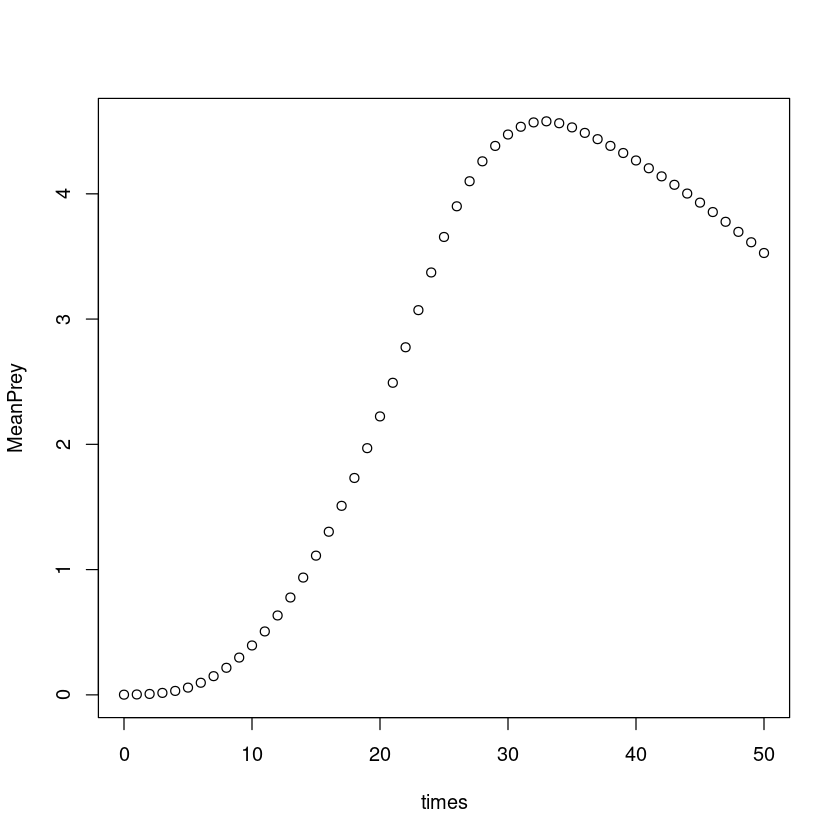

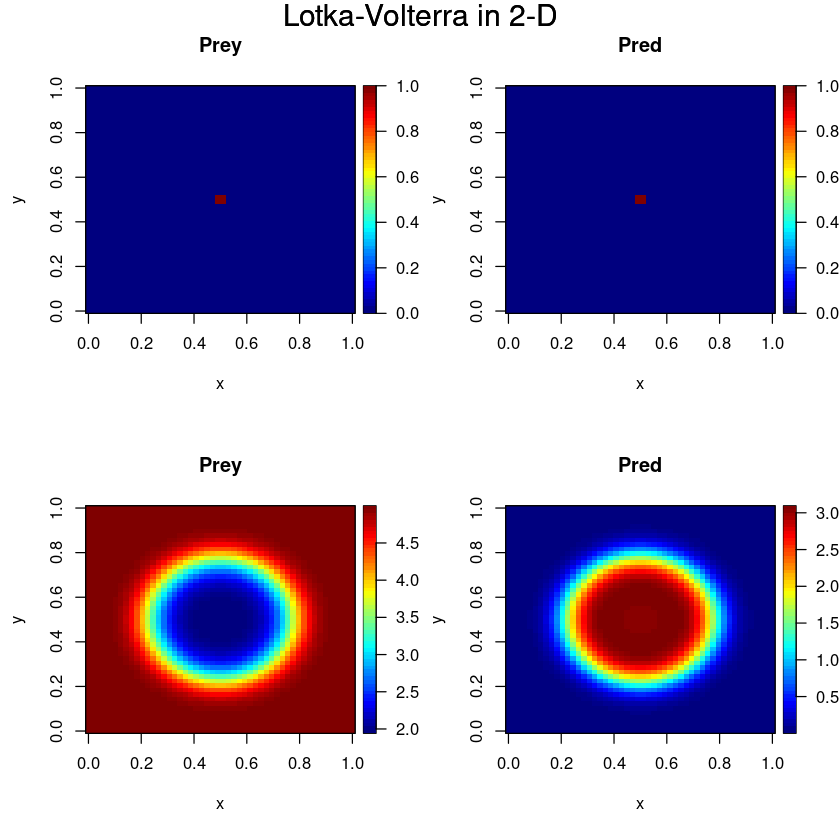

In [6]:
# Mean of prey concentration at each time step
Prey <- subset(out, select = "Prey", arr = TRUE)
dim(Prey)
MeanPrey <- apply(Prey, MARGIN = 3, FUN = mean)
plot(times, MeanPrey)

if (FALSE) {
## plot results
Col <- colorRampPalette(c("#00007F", "blue", "#007FFF", "cyan",
                          "#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"))

for (i in seq(1, length(times), by = 1))
   image(Prey[ , ,i],
   col = Col(100), xlab = , zlim = range(out[,2:(NN+1)]))

## similar, plotting both and adding a margin text with times:
image(out, xlab = "x", ylab = "y", mtext = paste("time = ", times))
}

select <- c(1, 40)
image(out, xlab = "x", ylab = "y", mtext = "Lotka-Volterra in 2-D",
      subset = select, mfrow = c(2,2), legend =  TRUE)

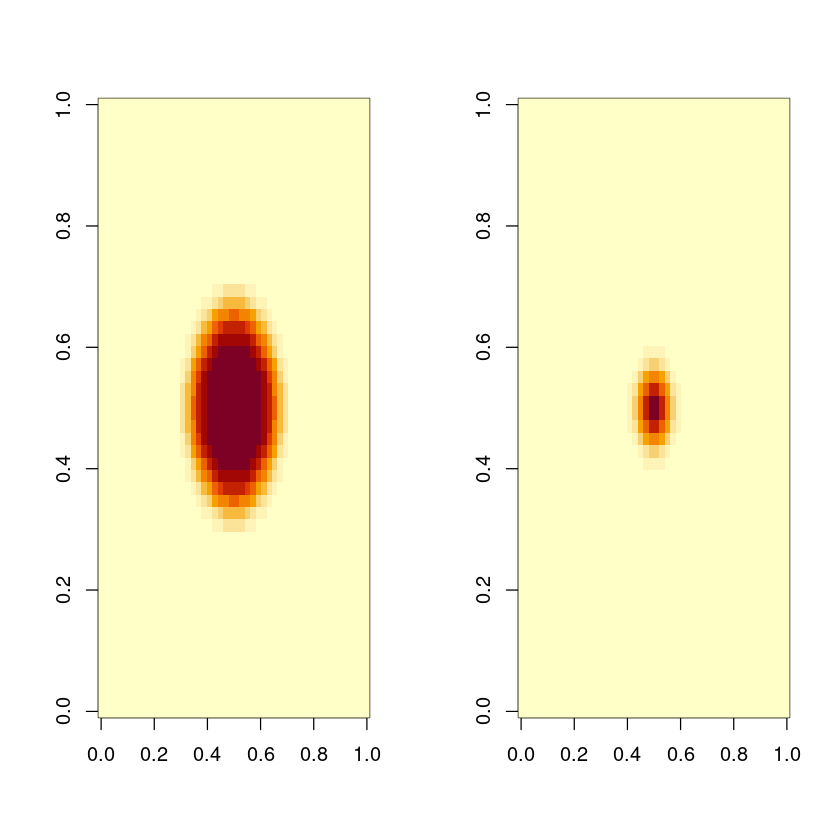

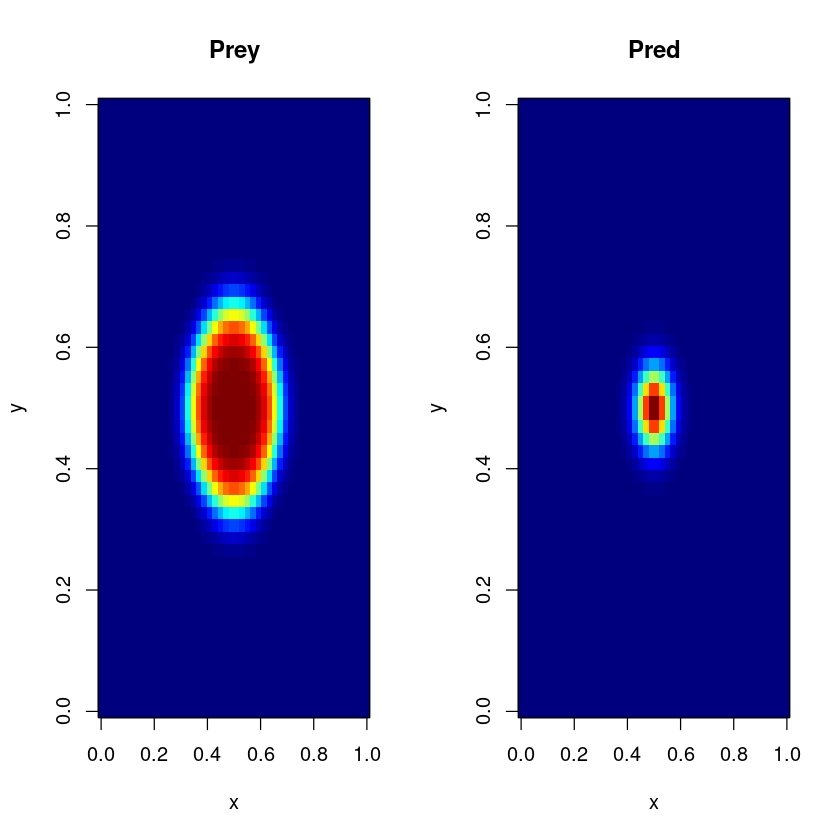

In [7]:
# plot prey and pred at t = 10; first use subset to select data
prey10 <-  matrix (nrow = N, ncol = N, 
     data = subset(out, select = "Prey", subset = (time == 10)))
pred10 <-  matrix (nrow = N, ncol = N, 
     data = subset(out, select = "Pred", subset = (time == 10)))

mf <- par(mfrow = c(1, 2))
image(prey10)
image(pred10)
par (mfrow = mf)

# same, using deSolve's image:
image(out, subset = (time == 10))